In [ ]:
# import pandas as pd 
# # Read data from file 'filename.csv' 
# # (in the same directory that your python process is based)
# # Control delimiters, rows, column names with read_csv (see later) 
# data = pd.read_csv("lottery.csv", header=None, names=['date', '1', '2', '3', '4', '5', '6', '7']) 
# del data['7']
# # Preview the first 5 lines of the loaded data 
# data.head()


In [ ]:
# def processInput(col, backward):
#     inputs = data[col].values.tolist()
#     X = []
#     y = []
#     for i in range(0, len(inputs) - backward):
#         y.append(inputs[i])
#         X.append(inputs[i + 1: i + 1 + backward])
#     return X, y
    
# X, y = processInput('5', 10)

In [ ]:
# print('hello')

In [ ]:
# from sklearn.datasets import fetch_openml
# from sklearn.exceptions import ConvergenceWarning
# from sklearn.neural_network import MLPClassifier

# X_train, X_test = X[:2962], X[2962:]
# y_train, y_test = y[:2962], y[2962:]

# mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10000, alpha=1e-4,
#                     solver='sgd', verbose=10, random_state=1,
#                     learning_rate_init=.1)

# mlp.fit(X_train, y_train)

# print("Training set score: %f" % mlp.score(X_train, y_train))
# print("Test set score: %f" % mlp.score(X_test, y_test))

In [ ]:
# from sklearn.datasets import fetch_openml
# from sklearn.exceptions import ConvergenceWarning
# from sklearn.neural_network import MLPClassifier

# print(__doc__)

# # Load data from https://www.openml.org/d/554
# X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X / 255.

In [ ]:
y

In [ ]:
# X_train, X_test = X[:60000], X[60000:]
# y_train, y_test = y[:60000], y[60000:]

# mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
#                     solver='sgd', verbose=10, random_state=1,
#                     learning_rate_init=.1)

# mlp.fit(X_train, y_train)

# print("Training set score: %f" % mlp.score(X_train, y_train))
# print("Test set score: %f" % mlp.score(X_test, y_test))

In [ ]:
# Download CSV stock price https://query1.finance.yahoo.com/v7/finance/download/SPY?period1=1451433600&period2=1606694400&interval=1d&events=history&includeAdjustedClose=true


In [5]:
# import csv
# import requests

# stocks = ['SPY', 'TWTR', 'SQ', 'AMZN', 'CRSP']
# for t in stocks:
#     csv_url = "https://query1.finance.yahoo.com/v7/finance/download/{}?period1=1451433600&period2=1606694400&interval=1d&events=history&includeAdjustedClose=true".format(t)
#     req = requests.get(csv_url)
#     url_content = req.content
#     csv_file = open('db1/{}.csv'.format(t), 'wb')
#     csv_file.write(url_content)
#     csv_file.close()

In [3]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")
# Neural Network library
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



# Technical Analysis library
import ta

def run_stock(file_name):
    # Loading in the Data
    df = pd.read_csv("db/{}.csv".format(file_name))
    ## Datetime conversion
    df['Date'] = pd.to_datetime(df.Date)

    # Setting the index
    df.set_index('Date', inplace=True)

    # Dropping any NaNs
    df.dropna(inplace=True)
    
    df = df.pct_change()


    ## Technical Indicators

    # Adding all the indicators
    df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

    # Dropping everything else besides 'Close' and the Indicators
    df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

    # Only using the last 1000 days of data to get a more accurate representation of the current market climate
    df = df.tail(1000)



    ## Scaling

    # Scale fitting the close prices separately for inverse_transformations purposes later
    close_scaler = RobustScaler()

    close_scaler.fit(df[['Close']])

    # Normalizing/Scaling the DF
    scaler = RobustScaler()

    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

    def split_sequence(seq, n_steps_in, n_steps_out):
        """
        Splits the multivariate time sequence
        """

        # Creating a list for both variables
        X, y = [], []

        for i in range(len(seq)):

            # Finding the end of the current sequence
            end = i + n_steps_in
            out_end = end + n_steps_out

            # Breaking out of the loop if we have exceeded the dataset's length
            if out_end > len(seq):
                break

            # Splitting the sequences into: x = past prices and indicators, y = prices ahead
            seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]

            X.append(seq_x)
            y.append(seq_y)

        return np.array(X), np.array(y)


    def visualize_training_results(results):
        """
        Plots the loss and accuracy for the training and testing data
        """
        history = results.history
        plt.figure(figsize=(16,5))
        plt.plot(history['val_loss'])
        plt.plot(history['loss'])
        plt.legend(['val_loss', 'loss'])
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()

        plt.figure(figsize=(16,5))
        plt.plot(history['val_accuracy'])
        plt.plot(history['accuracy'])
        plt.legend(['val_accuracy', 'accuracy'])
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.show()


    def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
        """
        Creates a specified number of hidden layers for an RNN
        Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
        """

        # Creating the specified number of hidden layers with the specified number of nodes
        for x in range(1,n_layers+1):
            model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

            # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
            try:
                if x % drop == 0:
                    model.add(Dropout(d_rate))
            except:
                pass


    def validater(n_per_in, n_per_out):
        """
        Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
        Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
        """

        # Creating an empty DF to store the predictions
        predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

        for i in range(n_per_in, len(df)-n_per_in, n_per_out):
            # Creating rolling intervals to predict off of
            x = df[-i - n_per_in:-i]

            # Predicting using rolling intervals
            yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

            # Transforming values back to their normal prices
            yhat = close_scaler.inverse_transform(yhat)[0]

            # DF to store the values and append later, frequency uses business days
            pred_df = pd.DataFrame(yhat, 
                                   index=pd.date_range(start=x.index[-1], 
                                                       periods=len(yhat), 
                                                       freq="B"),
                                   columns=[x.columns[0]])

            # Updating the predictions DF
            predictions.update(pred_df)

        return predictions


    def val_rmse(df1, df2):
        """
        Calculates the root mean square error between the two Dataframes
        """
        df = df1.copy()

        # Adding a new column with the closing prices from the second DF
        df['close2'] = df2.Close

        # Dropping the NaN values
        df.dropna(inplace=True)

        # Adding another column containing the difference between the two DFs' closing prices
        df['diff'] = df.Close - df.close2

        # Squaring the difference and getting the mean
        rms = (df[['diff']]**2).mean()

        # Returning the sqaure root of the root mean square
        return float(np.sqrt(rms))


    # How many periods looking back to learn
    n_per_in  = 90
    # How many periods to predict
    n_per_out = 30
    # Features 
    n_features = df.shape[1]
    # Splitting the data into appropriate sequences
    X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)


    ## Creating the NN

    # Instatiating the model
    model = Sequential()

    # Activation
    activ = "tanh"

    # Input layer
    model.add(LSTM(90, 
                   activation=activ, 
                   return_sequences=True, 
                   input_shape=(n_per_in, n_features)))

    # Hidden layers
    layer_maker(n_layers=2, 
                n_nodes=50, 
                activation=activ)

    # Final Hidden layer
    model.add(LSTM(60, activation=activ))

    # Output layer
    model.add(Dense(n_per_out))

    # Model summary
    model.summary()

    # Compiling the data with selected specifications
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

    # Fitting and Training
    res = model.fit(X, y, epochs=100, batch_size=200, validation_split=0.1)

    visualize_training_results(res)

    # Transforming the actual values to their original price
    actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                          index=df.index, 
                          columns=[df.columns[0]])

    # Getting a DF of the predicted values to validate against
    predictions = validater(n_per_in, n_per_out)

    # Printing the RMSE
    print("RMSE:", val_rmse(actual, predictions))

    # # Plotting
    # plt.figure(figsize=(16,6))

    # # Plotting those predictions
    # plt.plot(predictions, label='Predicted')

    # # Plotting the actual values
    # plt.plot(actual, label='Actual')

    # plt.title(f"Predicted vs Actual Closing Prices")
    # plt.ylabel("Price")
    # plt.legend()
    # plt.xlim('2018-12', '2020-12')
    # plt.show()

    # Predicting off of the most recent days from the original DF
    yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

    # Transforming the predicted values back to their original format
    yhat = close_scaler.inverse_transform(yhat)[0]

    # Creating a DF of the predicted prices
    preds = pd.DataFrame(yhat, 
                         index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                             periods=len(yhat), 
                                             freq="B"), 
                         columns=[df.columns[0]])

    # Number of periods back to plot the actual values
    pers = n_per_in

    # Transforming the actual values to their original price
    actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                          index=df.Close.tail(pers).index, 
                          columns=[df.columns[0]]).append(preds.head(1))

    # Printing the predicted prices
    print(preds)

    preds.to_csv('{}-predicted.csv'.format('SPY'), index=True)  

    # # Plotting
    # plt.figure(figsize=(16,6))
    # plt.plot(actual, label="Actual Prices")
    # plt.plot(preds, label="Predicted Prices")
    # plt.ylabel("Price")
    # plt.xlabel("Dates")
    # plt.title(f"Forecasting the next {len(yhat)} days")
    # plt.legend()
    # plt.show()
    preds.to_csv('db/{}-predicted.csv'.format(file_name), index=True)  
    
    # Writing training data to file 
    with open("db/{}-training-data.csv".format(file_name), "w") as f: 
        for k, v in res.history.items():
            f.write(k + ',' + ','.join([str(i) for i in v]))
            f.write('\n')



C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 90, 90)            63000     
_________________________________________________________________
lstm_21 (LSTM)               (None, 90, 50)            28200     
_________________________________________________________________
lstm_22 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
lstm_23 (LSTM)               (None, 60)                26640     
_________________________________________________________________
dense_5 (Dense)              (None, 30)                1830      
Total params: 139,870
Trainable params: 139,870
Non-trainable params: 0
_________________________________________________________________
Train on 792 samples, validate on 89 samples
Epoch 1/100
792/792 [==============================] - 8s 10ms/sample

792/792 [==============================] - 0s 622us/sample - loss: 1.3138 - accuracy: 0.1010 - val_loss: 2.9633 - val_accuracy: 0.0787
Epoch 50/100
792/792 [==============================] - 0s 625us/sample - loss: 1.3107 - accuracy: 0.0909 - val_loss: 2.9671 - val_accuracy: 0.0674
Epoch 51/100
792/792 [==============================] - 0s 616us/sample - loss: 1.3091 - accuracy: 0.0960 - val_loss: 2.9680 - val_accuracy: 0.0899
Epoch 52/100
792/792 [==============================] - 0s 618us/sample - loss: 1.3064 - accuracy: 0.1111 - val_loss: 2.9797 - val_accuracy: 0.0787
Epoch 53/100
792/792 [==============================] - 0s 623us/sample - loss: 1.3046 - accuracy: 0.1010 - val_loss: 2.9851 - val_accuracy: 0.0899
Epoch 54/100
792/792 [==============================] - 1s 638us/sample - loss: 1.3015 - accuracy: 0.1048 - val_loss: 2.9961 - val_accuracy: 0.0674
Epoch 55/100
792/792 [==============================] - 1s 659us/sample - loss: 1.3005 - accuracy: 0.1048 - val_loss: 3.0120 

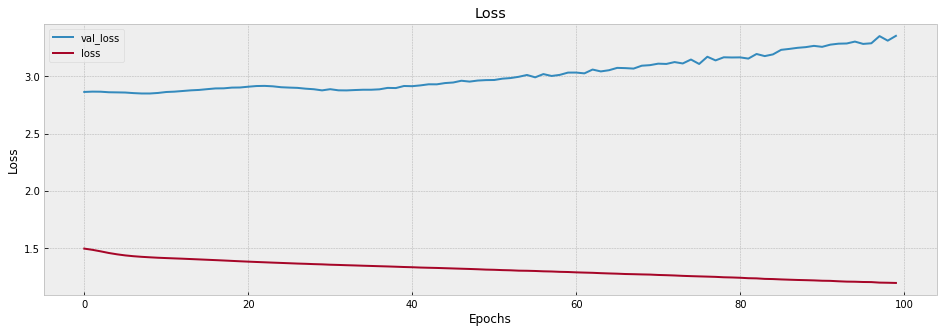

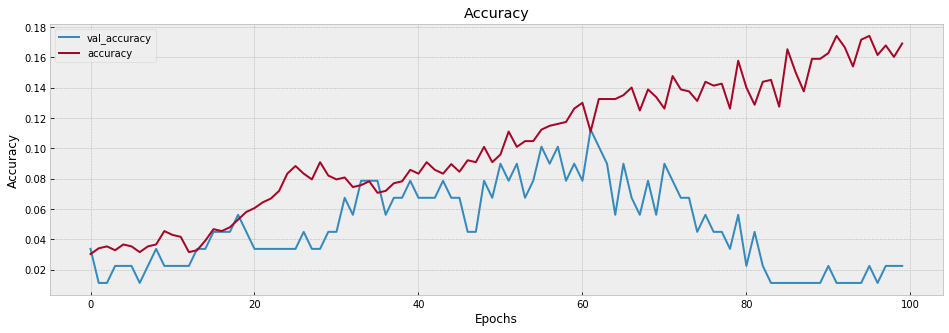

RMSE: 0.01944829771817739
               Close
2020-11-30  0.014946
2020-12-01  0.010248
2020-12-02  0.007975
2020-12-03  0.001367
2020-12-04 -0.002023
2020-12-07 -0.001313
2020-12-08 -0.001701
2020-12-09  0.001723
2020-12-10  0.006710
2020-12-11  0.009665
2020-12-14  0.007845
2020-12-15  0.006524
2020-12-16  0.005893
2020-12-17  0.004378
2020-12-18  0.004401
2020-12-21  0.005483
2020-12-22  0.003132
2020-12-23  0.003572
2020-12-24  0.001634
2020-12-25  0.003132
2020-12-28 -0.001068
2020-12-29  0.001516
2020-12-30  0.001241
2020-12-31 -0.002893
2021-01-01 -0.001451
2021-01-04 -0.000206
2021-01-05 -0.002776
2021-01-06 -0.001258
2021-01-07  0.003011
2021-01-08  0.002207


C:\Users\nlchu\anaconda3\lib\site-packages\ta\volume.py:319: RuntimeWarning: invalid value encountered in double_scalars
  self._nvi.iloc[i] = self._nvi.iloc[i - 1] * (1.0 + price_change.iloc[i])
C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 90, 90)            63000     
_________________________________________________________________
lstm_25 (LSTM)               (None, 90, 50)            28200     
_________________________________________________________________
lstm_26 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
lstm_27 (LSTM)               (None, 60)                26640     
_________________________________________________________________
dense_6 (Dense)              (None, 30)                1830      
Total params: 139,870
Trainable params: 139,870
Non-trainable params: 0
_________________________________________________________________
Train on 792 samples, validate on 89 samples
Epoch 1/100
792/792 [==============================] - 8s 10ms/sample

792/792 [==============================] - 0s 620us/sample - loss: 1.2132 - accuracy: 0.1439 - val_loss: 1.9334 - val_accuracy: 0.0000e+00
Epoch 50/100
792/792 [==============================] - 0s 620us/sample - loss: 1.2089 - accuracy: 0.1604 - val_loss: 1.9459 - val_accuracy: 0.0112
Epoch 51/100
792/792 [==============================] - 0s 615us/sample - loss: 1.2043 - accuracy: 0.1654 - val_loss: 1.9243 - val_accuracy: 0.0112
Epoch 52/100
792/792 [==============================] - 0s 614us/sample - loss: 1.1990 - accuracy: 0.1616 - val_loss: 1.9449 - val_accuracy: 0.0000e+00
Epoch 53/100
792/792 [==============================] - 0s 618us/sample - loss: 1.1962 - accuracy: 0.1578 - val_loss: 1.9561 - val_accuracy: 0.0225
Epoch 54/100
792/792 [==============================] - 0s 625us/sample - loss: 1.1920 - accuracy: 0.1540 - val_loss: 1.9527 - val_accuracy: 0.0112
Epoch 55/100
792/792 [==============================] - 0s 619us/sample - loss: 1.1870 - accuracy: 0.1616 - val_loss:

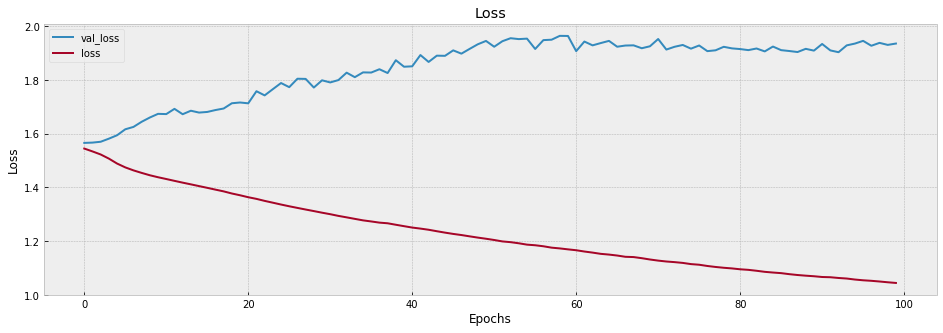

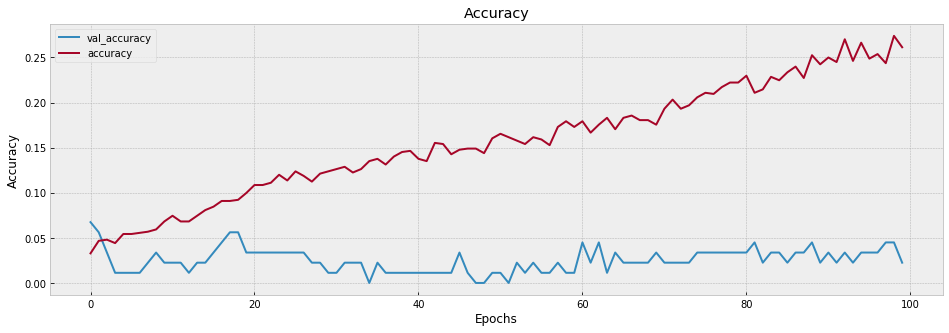

RMSE: 0.030442696391774875
               Close
2020-11-30 -0.015489
2020-12-01  0.004520
2020-12-02 -0.009423
2020-12-03 -0.007650
2020-12-04 -0.008914
2020-12-07 -0.006635
2020-12-08  0.000163
2020-12-09 -0.002041
2020-12-10 -0.015152
2020-12-11 -0.005701
2020-12-14 -0.003595
2020-12-15  0.010970
2020-12-16  0.013776
2020-12-17  0.011671
2020-12-18  0.004194
2020-12-21  0.007845
2020-12-22  0.006820
2020-12-23  0.005651
2020-12-24  0.006931
2020-12-25  0.016234
2020-12-28  0.019053
2020-12-29  0.017498
2020-12-30  0.017142
2020-12-31  0.007690
2021-01-01  0.012932
2021-01-04  0.019321
2021-01-05  0.017641
2021-01-06  0.016443
2021-01-07  0.009029
2021-01-08  0.015065


C:\Users\nlchu\anaconda3\lib\site-packages\ta\volume.py:319: RuntimeWarning: invalid value encountered in double_scalars
  self._nvi.iloc[i] = self._nvi.iloc[i - 1] * (1.0 + price_change.iloc[i])
C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 90, 90)            63000     
_________________________________________________________________
lstm_29 (LSTM)               (None, 90, 50)            28200     
_________________________________________________________________
lstm_30 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
lstm_31 (LSTM)               (None, 60)                26640     
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1830      
Total params: 139,870
Trainable params: 139,870
Non-trainable params: 0
_________________________________________________________________
Train on 792 samples, validate on 89 samples
Epoch 1/100
792/792 [==============================] - 7s 9ms/sample 

792/792 [==============================] - 0s 624us/sample - loss: 1.0342 - accuracy: 0.1212 - val_loss: 1.4727 - val_accuracy: 0.0562
Epoch 50/100
792/792 [==============================] - 0s 624us/sample - loss: 1.0307 - accuracy: 0.1149 - val_loss: 1.4707 - val_accuracy: 0.0449
Epoch 51/100
792/792 [==============================] - 0s 622us/sample - loss: 1.0287 - accuracy: 0.1149 - val_loss: 1.5054 - val_accuracy: 0.0449
Epoch 52/100
792/792 [==============================] - 0s 620us/sample - loss: 1.0263 - accuracy: 0.1237 - val_loss: 1.4810 - val_accuracy: 0.0562
Epoch 53/100
792/792 [==============================] - 1s 632us/sample - loss: 1.0243 - accuracy: 0.1149 - val_loss: 1.4757 - val_accuracy: 0.0449
Epoch 54/100
792/792 [==============================] - 0s 615us/sample - loss: 1.0212 - accuracy: 0.1263 - val_loss: 1.5151 - val_accuracy: 0.0562
Epoch 55/100
792/792 [==============================] - 0s 618us/sample - loss: 1.0199 - accuracy: 0.1237 - val_loss: 1.5132 

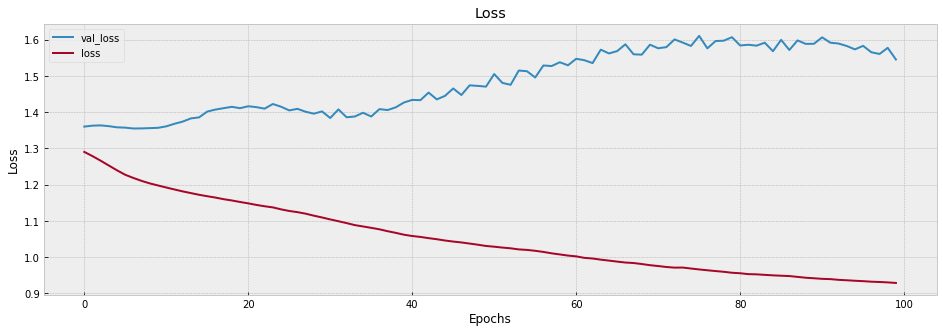

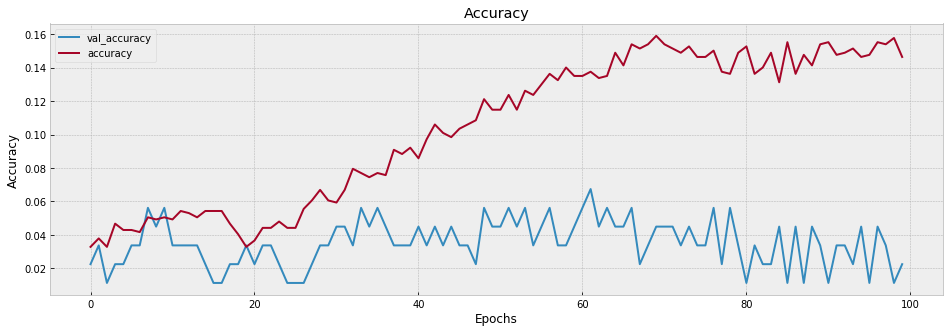

RMSE: 0.033064427238018286
               Close
2020-11-30  0.033128
2020-12-01  0.035705
2020-12-02  0.030615
2020-12-03  0.011767
2020-12-04  0.009142
2020-12-07  0.001000
2020-12-08  0.002617
2020-12-09  0.001462
2020-12-10  0.002386
2020-12-11  0.000726
2020-12-14 -0.001740
2020-12-15 -0.002563
2020-12-16 -0.005883
2020-12-17 -0.008082
2020-12-18 -0.002340
2020-12-21  0.003336
2020-12-22  0.003567
2020-12-23  0.020134
2020-12-24  0.021159
2020-12-25  0.028126
2020-12-28  0.015207
2020-12-29  0.018580
2020-12-30  0.001727
2020-12-31  0.000017
2021-01-01 -0.003201
2021-01-04 -0.001418
2021-01-05 -0.003379
2021-01-06  0.005399
2021-01-07  0.008918
2021-01-08 -0.000502


C:\Users\nlchu\anaconda3\lib\site-packages\ta\volume.py:319: RuntimeWarning: invalid value encountered in double_scalars
  self._nvi.iloc[i] = self._nvi.iloc[i - 1] * (1.0 + price_change.iloc[i])
C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 90, 90)            63000     
_________________________________________________________________
lstm_33 (LSTM)               (None, 90, 50)            28200     
_________________________________________________________________
lstm_34 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
lstm_35 (LSTM)               (None, 60)                26640     
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1830      
Total params: 139,870
Trainable params: 139,870
Non-trainable params: 0
_________________________________________________________________
Train on 792 samples, validate on 89 samples
Epoch 1/100
792/792 [==============================] - 7s 9ms/sample 

792/792 [==============================] - 0s 611us/sample - loss: 1.0100 - accuracy: 0.1250 - val_loss: 2.1993 - val_accuracy: 0.0225
Epoch 50/100
792/792 [==============================] - 0s 620us/sample - loss: 1.0083 - accuracy: 0.1275 - val_loss: 2.2388 - val_accuracy: 0.0225
Epoch 51/100
792/792 [==============================] - 0s 622us/sample - loss: 1.0061 - accuracy: 0.1225 - val_loss: 2.1961 - val_accuracy: 0.0225
Epoch 52/100
792/792 [==============================] - 0s 621us/sample - loss: 1.0035 - accuracy: 0.1250 - val_loss: 2.2379 - val_accuracy: 0.0112
Epoch 53/100
792/792 [==============================] - 0s 617us/sample - loss: 1.0010 - accuracy: 0.1199 - val_loss: 2.2163 - val_accuracy: 0.0112
Epoch 54/100
792/792 [==============================] - 0s 613us/sample - loss: 0.9980 - accuracy: 0.1250 - val_loss: 2.2360 - val_accuracy: 0.0225
Epoch 55/100
792/792 [==============================] - 0s 614us/sample - loss: 0.9967 - accuracy: 0.1301 - val_loss: 2.2292 

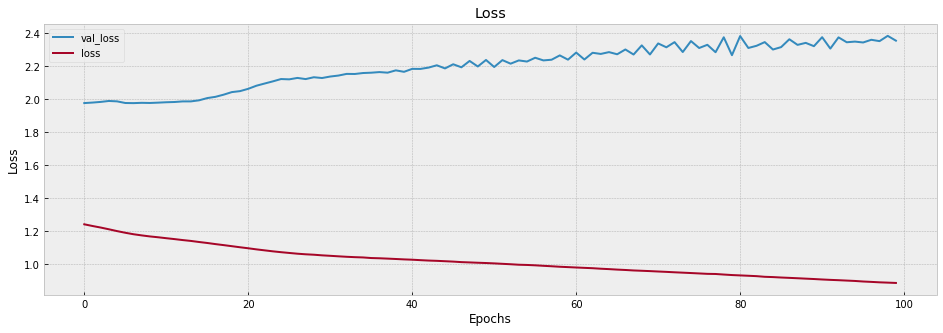

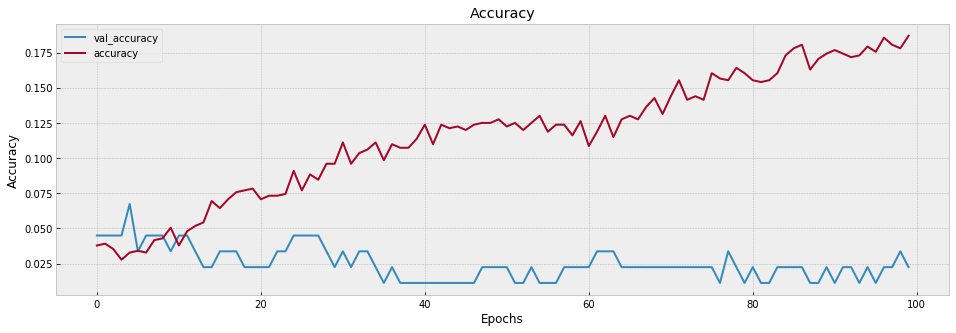

RMSE: 0.018812727118589157
               Close
2020-11-30 -0.000834
2020-12-01  0.002331
2020-12-02  0.001215
2020-12-03  0.004635
2020-12-04 -0.006828
2020-12-07 -0.011401
2020-12-08 -0.023124
2020-12-09 -0.031001
2020-12-10 -0.028966
2020-12-11 -0.017632
2020-12-14  0.001610
2020-12-15  0.006628
2020-12-16  0.008069
2020-12-17 -0.000150
2020-12-18  0.003156
2020-12-21 -0.001697
2020-12-22 -0.009189
2020-12-23  0.001992
2020-12-24 -0.002807
2020-12-25 -0.000211
2020-12-28  0.008364
2020-12-29 -0.004220
2020-12-30 -0.012924
2020-12-31 -0.014456
2021-01-01 -0.011140
2021-01-04  0.005900
2021-01-05 -0.000061
2021-01-06 -0.005141
2021-01-07  0.000105
2021-01-08  0.006141


C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\nlchu\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 90, 90)            63000     
_________________________________________________________________
lstm_37 (LSTM)               (None, 90, 50)            28200     
_________________________________________________________________
lstm_38 (LSTM)               (None, 90, 50)            20200     
_________________________________________________________________
lstm_39 (LSTM)               (None, 60)                26640     
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1830      
Total params: 139,870
Trainable params: 139,870
Non-trainable params: 0
_________________________________________________________________
Train on 792 samples, validate on 89 samples
Epoch 1/100
792/792 [==============================] - 6s 8ms/sample 

792/792 [==============================] - 0s 617us/sample - loss: 0.8108 - accuracy: 0.1553 - val_loss: 0.9856 - val_accuracy: 0.0225
Epoch 50/100
792/792 [==============================] - 1s 632us/sample - loss: 0.8100 - accuracy: 0.1528 - val_loss: 0.9951 - val_accuracy: 0.0225
Epoch 51/100
792/792 [==============================] - 0s 608us/sample - loss: 0.8091 - accuracy: 0.1692 - val_loss: 0.9847 - val_accuracy: 0.0225
Epoch 52/100
792/792 [==============================] - 1s 643us/sample - loss: 0.8077 - accuracy: 0.1566 - val_loss: 1.0037 - val_accuracy: 0.0225
Epoch 53/100
792/792 [==============================] - 0s 608us/sample - loss: 0.8072 - accuracy: 0.1679 - val_loss: 0.9919 - val_accuracy: 0.0225
Epoch 54/100
792/792 [==============================] - 0s 628us/sample - loss: 0.8055 - accuracy: 0.1503 - val_loss: 1.0014 - val_accuracy: 0.0112
Epoch 55/100
792/792 [==============================] - 0s 611us/sample - loss: 0.8045 - accuracy: 0.1540 - val_loss: 0.9961 

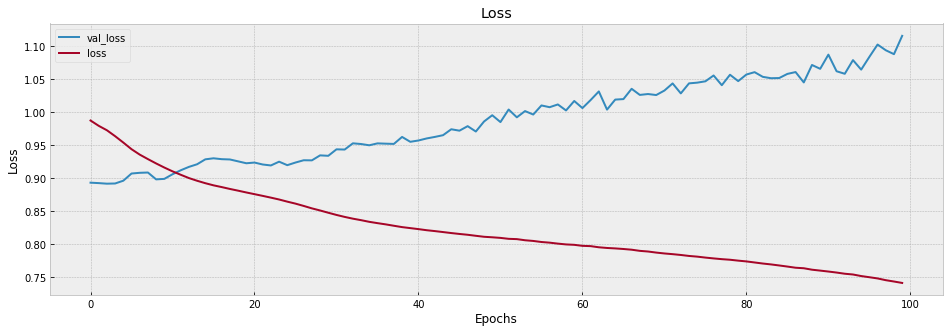

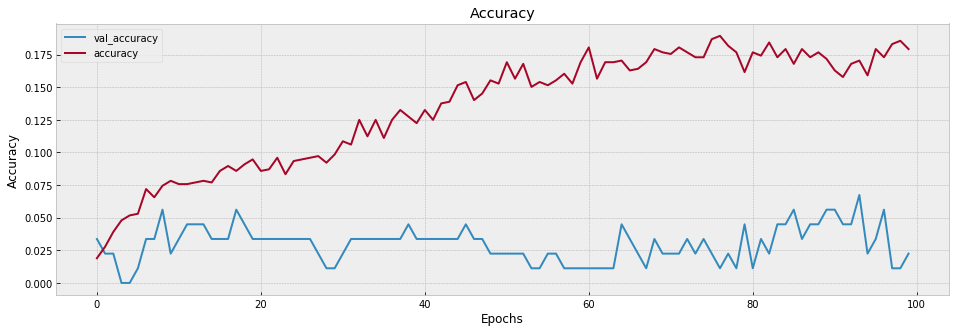

RMSE: 0.039336761653288616
               Close
2020-11-30  0.032634
2020-12-01  0.031126
2020-12-02  0.013837
2020-12-03  0.016878
2020-12-04  0.017298
2020-12-07  0.020009
2020-12-08  0.017417
2020-12-09 -0.010439
2020-12-10  0.008814
2020-12-11  0.001810
2020-12-14  0.004490
2020-12-15 -0.005689
2020-12-16  0.002156
2020-12-17 -0.001225
2020-12-18  0.014516
2020-12-21  0.011021
2020-12-22  0.015374
2020-12-23  0.003110
2020-12-24 -0.007361
2020-12-25 -0.017100
2020-12-28 -0.007704
2020-12-29 -0.031996
2020-12-30 -0.011974
2020-12-31 -0.027353
2021-01-01 -0.025575
2021-01-04 -0.013926
2021-01-05 -0.034954
2021-01-06 -0.036618
2021-01-07 -0.037828
2021-01-08 -0.026638


In [4]:
stocks = ['AAPL', 'TWTR', 'SQ', 'AMZN', 'CRSP']

for s in stocks:
    run_stock(s)
